In [75]:
%reset

In [2]:
import torch
import torchvision
from torchvision import datasets
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Subset

In [3]:
transform_train = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.3),
     transforms.RandomVerticalFlip(0.3),
     transforms.RandomRotation(15),
     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
     transforms.ToTensor(),
     transforms.RandomErasing(0.1),
     transforms.GaussianBlur(1.0),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
transform_val = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
)

# Load and split data

In [8]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.dataset)

In [39]:
DATA_PATH = "../train/"
dataset = datasets.ImageFolder(root=DATA_PATH)
idx_to_class = tuple([k for k, _ in dataset.class_to_idx.items()])
torch.manual_seed(42)
n_train_examples = int(len(dataset) * 0.6)
n_val_examples = len(dataset) - n_train_examples
train_indices, val_indices = random_split(range(len(dataset)), [n_train_examples, n_val_examples])
train_dataset = CustomDataset(Subset(dataset, train_indices), transform=transform_train)
val_dataset = CustomDataset(Subset(dataset, val_indices), transform=transform_val)

In [40]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6)

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Peek data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


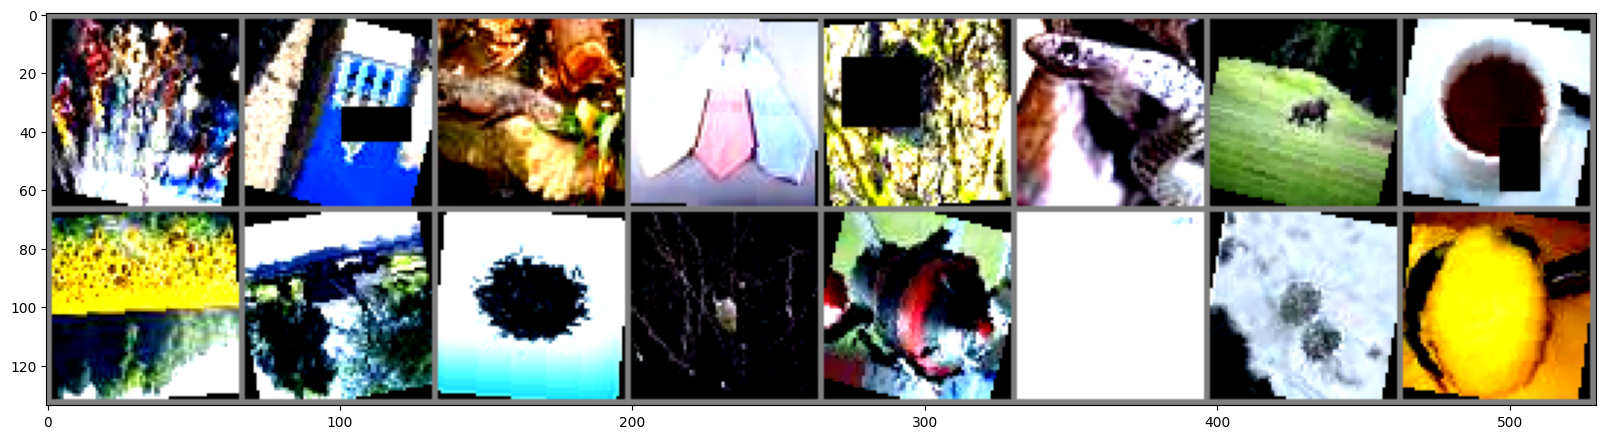

gauge acoustic crocodilian towel nest snake swine tea flower truck carbon bird bomb frog bacteria icecream


In [42]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))

# get some random training images
images, labels = next(iter(train_loader))


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

print(" ".join(f"{idx_to_class[labels[j]]}" for j in range(batch_size)))

In [8]:
images[0:1].size()

torch.Size([1, 3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


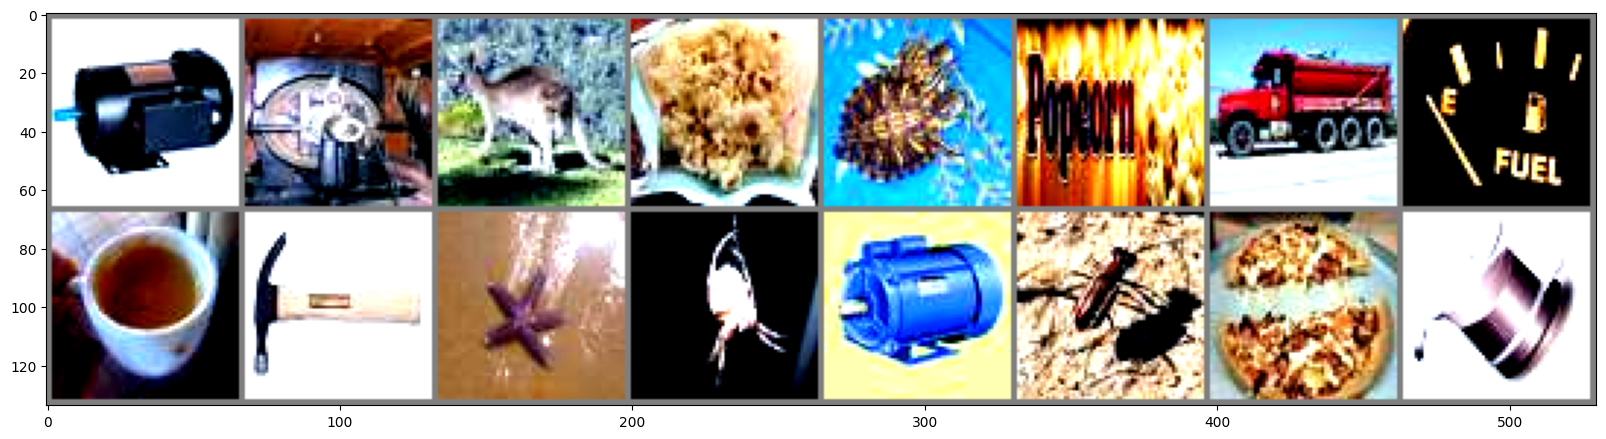

motor motor kangaroo corn turtle corn truck gauge tea hammer echinoderm spider motor beetle pizza pot


In [9]:
plt.figure(figsize=(20, 10))

# get some random training images
images, labels = next(iter(val_loader))


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = next(iter(val_loader))

# show images
imshow(torchvision.utils.make_grid(images))

print(" ".join(f"{idx_to_class[labels[j]]}" for j in range(batch_size)))

In [4]:
class CNN(nn.Module):
    def __init__(self, output_size):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(128, 192, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(192)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(192, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((None, 6))
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(2688, 1028)
        self.fc2 = nn.Linear(1028, 512)
        self.fc3 = nn.Linear(512, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.maxpool4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [44]:
model = CNN(len(dataset.classes)).to(device)

In [45]:
model

CNN(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPoo

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=0.0001)

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
mca = MulticlassAccuracy(num_classes=50, average=None).to(device)
EPOCHS_NUMBER = 30
(
    train_losses,
    train_accuracies,
    val_losses,
    val_accuracies,
    train_f1_scores,
    val_f1_scores,
) = ([], [], [], [], [], [])
tqdm_progress = tqdm(range(EPOCHS_NUMBER))

t_batch_num, v_batch_num = len(train_loader), len(val_loader)

for epoch in tqdm_progress:
    train_batch_loss_sum, val_batch_loss_sum = 0, 0
    train_batch_accuracy_sum, val_batch_accuracy_sum = 0, 0
    train_batch_f1_score_sum, val_batch_f1_score_sum = 0, 0

    model.train()
    for data_patch, label in train_loader:
        data_patch, label = data_patch.to(device), label.to(device)
        optimizer.zero_grad()
        model_output = model(data_patch).squeeze()
        loss = criterion(model_output, label)
        loss.backward()
        optimizer.step()
        train_batch_loss_sum += loss.item()

    train_batch_loss_avg = train_batch_loss_sum / t_batch_num
    train_batch_accuracy_avg = train_batch_accuracy_sum / t_batch_num

    train_losses.append(train_batch_loss_avg)
    train_accuracies.append(train_batch_accuracy_avg)

    model.eval()
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_predicts = model(val_inputs).squeeze(dim=1)
        val_loss = criterion(val_predicts, val_labels)
        val_batch_loss_sum += val_loss.item()
        val_batch_accuracy_sum += mca(torch.argmax(val_predicts, dim=1), val_labels)

    val_batch_loss_avg = val_batch_loss_sum / v_batch_num
    val_batch_accuracy_avg = val_batch_accuracy_sum / v_batch_num

    val_accuracies.append(val_batch_accuracy_avg)
    val_losses.append(val_batch_loss_avg)

    tqdm_progress.set_postfix(
        {
            "Epoch": epoch + 1,
            "Los in train": {train_batch_loss_avg},
            "Loss in eval": {val_batch_loss_avg},
        }
    )


0it [09:06, ?it/s]
  0%|          | 0/30 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [88]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
labels_train, labels_val = torch.tensor([], device=device), torch.tensor([], device=device)
predicted_train, predicted_val = torch.tensor([], device=device), torch.tensor([], device=device)
model.eval()
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        predicts_train = model(inputs)
        predicted_argmax_train = torch.argmax(predicts_train, dim=1)
        labels_train = torch.cat((labels_train, labels))
        predicted_train = torch.cat((predicted_train, predicted_argmax_train))

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        predicts_val = model(inputs)
        predicted_argmax_val = torch.argmax(predicts_val, dim=1)
        labels_val = torch.cat((labels_val, labels))
        predicted_val = torch.cat((predicted_val, predicted_argmax_val))


In [89]:
labels_train, predicted_train = labels_train.cpu() , predicted_train.cpu()
labels_val, predicted_val = labels_val.cpu() , predicted_val.cpu()

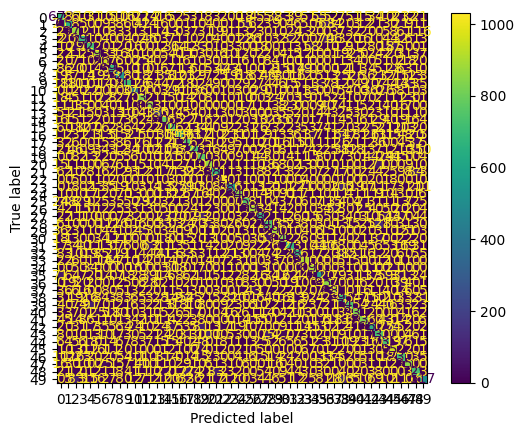

In [90]:
confusion_matrix_train = confusion_matrix(labels_train , predicted_train)
ConfusionMatrixDisplay(confusion_matrix_train).plot()
plt.show()

In [91]:
f1_score(labels_train, predicted_train, average='micro')

0.7068325569064121

In [92]:
mca_eval = MulticlassAccuracy(num_classes=50, average=None)

In [93]:
mca_eval(predicted_train, labels_train)

tensor([0.6159, 0.6296, 0.8139, 0.6404, 0.6760, 0.8116, 0.8747, 0.6490, 0.4926,
        0.6465, 0.5877, 0.7924, 0.7967, 0.5806, 0.7371, 0.6833, 0.4757, 0.6952,
        0.6682, 0.7073, 0.8140, 0.6435, 0.9635, 0.5487, 0.7850, 0.6957, 0.8139,
        0.6187, 0.6584, 0.8105, 0.7841, 0.6402, 0.6268, 0.8450, 0.8437, 0.5465,
        0.8070, 0.8097, 0.6309, 0.6757, 0.7990, 0.7586, 0.6033, 0.6765, 0.6682,
        0.8808, 0.6947, 0.8213, 0.6897, 0.4814])

In [94]:
f1_score(labels_val, predicted_val, average='micro')

0.6367277375372816

In [95]:
mca_eval(predicted_val, labels_val)

tensor([0.4993, 0.5339, 0.7000, 0.5634, 0.6161, 0.7389, 0.7897, 0.5455, 0.4559,
        0.5994, 0.4442, 0.7007, 0.7535, 0.3782, 0.6868, 0.5924, 0.4260, 0.6121,
        0.5636, 0.6085, 0.7836, 0.6011, 0.9316, 0.4859, 0.7254, 0.6260, 0.8125,
        0.4936, 0.6224, 0.7645, 0.7365, 0.5641, 0.4801, 0.7737, 0.8022, 0.4877,
        0.7241, 0.7261, 0.6071, 0.5887, 0.7762, 0.7464, 0.5316, 0.6531, 0.6114,
        0.8078, 0.5728, 0.7839, 0.5841, 0.3623])

In [96]:
mca_eval = MulticlassAccuracy(num_classes=50, average='macro')
mca_eval(predicted_val, labels_val)

tensor(0.6315)

Text(0, 0.5, 'Loss')

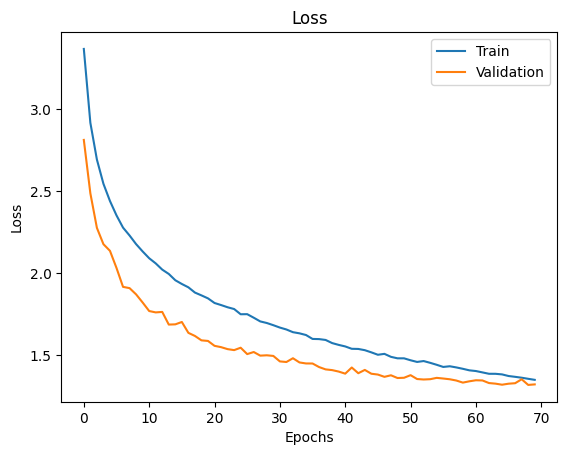

In [98]:

plt.plot(train_losses, label="Train")
plt.plot(val_losses, label = "Validation")
plt.legend()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Save model's state dict

In [99]:
path = "../models/m.pth"
torch.save(model.state_dict(), path)

# Train on full data

In [9]:
DATA_PATH = "../train/"
dataset = datasets.ImageFolder(root=DATA_PATH)
train_dataset = CustomDataset(dataset, transform=transform_train)


In [49]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [51]:
model = CNN(len(dataset.classes)).to(device)

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
mca = MulticlassAccuracy(num_classes=50, average=None).to(device)
EPOCHS_NUMBER = 100
tqdm_progress = tqdm(range(EPOCHS_NUMBER))

t_batch_num= len(train_loader)

for epoch in tqdm_progress:
    model.train()
    for data_patch, label in train_loader:
        data_patch, label = data_patch.to(device), label.to(device)
        optimizer.zero_grad()
        model_output = model(data_patch).squeeze()
        loss = criterion(model_output, label)
        loss.backward()
        optimizer.step()
    tqdm_progress.set_postfix(
        {
            "Epoch": epoch + 1
        }
    )

 35%|███▌      | 35/100 [20:53<38:46, 35.79s/it, Epoch=35]

### Save model

In [114]:
# path = "../models/model_all_data_trained.pth"
# torch.save(model.state_dict(), path)

## Load test dataset

In [18]:
TEST_DATA_PATH = "../test"
test_dataset = datasets.ImageFolder(root=TEST_DATA_PATH)


In [12]:
model = CNN(len(dataset.classes)).to(device)
model.load_state_dict(torch.load("../models/model_66.pth"))

<All keys matched successfully>

In [20]:
import os
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
predictions = []
filenames = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        predicts_test = model(inputs)
        predicted_argmax_test = torch.argmax(predicts_test, dim=1)

        filenames.extend([os.path.basename(test_dataset.imgs[i][0]) for i in range(inputs.size(0))])
        predictions.extend(predicted_argmax_test.cpu().numpy())


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

## Save predictions

In [33]:
# result = pd.DataFrame({"Filename": filenames, "Predicted": predictions})
# result.to_csv("../predictions/predictions.csv", index=False, header=False)